In [1]:
# utility modules
import glob
import os
import sys
import re
import io

# the usual suspects
import numpy as np
import cartopy.crs as ccrs
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.img_tiles as cimgt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# import matplotlib.image as mpimg

# modules you'll need if you're downloading the data
from icepyx import icesat2data as ipd
import shutil
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, Polygon

import fiona
import pyproj
import h5py

# # run matplotlib in 'widget' mode
# %matplotlib widget
# %load_ext autoreload
# %autoreload 2

In [5]:
from readers.read_HDF5_ATL13 import read_HDF5_ATL13
ATL13_file = 'ATL13_20190429114134_04770301_003_01.h5'
IS2_atl13_mds, IS2_atl13_attrs, IS2_atl13_beams = read_HDF5_ATL13(ATL13_file)
beam = ['gt1l','gt1r','gt2l','gt2r','gt3l','gt3r']

In [6]:
fiona.drvsupport.supported_drivers['kml'] = 'rw' 
fiona.drvsupport.supported_drivers['KML'] = 'rw'
lake_filepath = os.getcwd()+'/sikkimlakes.kml'
gdfl = gpd.read_file(lake_filepath) 
mask = gdfl.geometry.unary_union
 
D13 = {}
stdev = []
surface = 0
for i in beam:
    D13[i] = {}    
    flag = np.zeros(IS2_atl13_mds[i]['segment_lon'].size, dtype=bool)
    for j in range(0, IS2_atl13_mds[i]['segment_lon'].size):
        flag[j] = (Point(IS2_atl13_mds[i]['segment_lon'][j],IS2_atl13_mds[i]['segment_lat'][j]).within(mask)) & (IS2_atl13_mds[i]['segment_lat'][j]>28.3)
    D13[i]['lon'] = IS2_atl13_mds[i]['segment_lon'][flag]
    D13[i]['lat'] = IS2_atl13_mds[i]['segment_lat'][flag]
    D13[i]['h_ortho'] = IS2_atl13_mds[i]['ht_ortho'][flag]
    D13[i]['ice_flag'] = IS2_atl13_mds[i]['ice_flag'][flag]
    stdev = np.append(stdev, D13[i]['h_ortho'][~np.isnan(D13[i]['h_ortho'])])
    # calculate the mean surface height of lake
    surface = surface + np.average(D13[i]['h_ortho'][~np.isnan(D13[i]['h_ortho'])])
surface /= len(beam)
print(surface)
stdev = np.std(stdev)
print(stdev)

4422.267985026042
0.06260917535201214


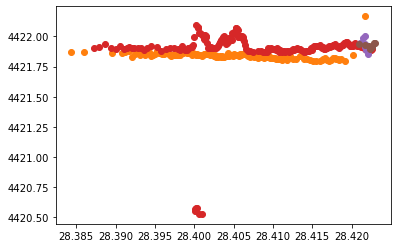

In [4]:
for gtx in ['gt1l','gt1r','gt2l','gt2r','gt3l','gt3r']:
    flag = (D13[gtx]['h_ortho']>0)
    y = plt.scatter(D13[gtx]['lat'][flag],D13[gtx]['h_ortho'])#[flag])
plt.show()  